In [ ]:
# Importing all requirements and libraries
!pip install wordcloud
!pip install textblob
!pip install tensorflow

import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from wordcloud import WordCloud
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# loading the dataset

# Read the dataset from the corrected URL
url = "https://raw.githubusercontent.com/sharmaroshan/Amazon-Alexa-Reviews/master/amazon_alexa.tsv"
data = pd.read_csv(url, delimiter='\t')

In [3]:
# Creating a new column sentiment based on overall ratings
def sentiments(df):
    if df['rating'] > 3.0:
        return 'Positive'
    elif df ['rating'] <= 3.0:
        return 'Negative'

data['sentiment'] = data.apply (sentiments,axis=1)

In [4]:
data.head()

,rating,date,variation,verified_reviews,feedback,sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Positive
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,Positive
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,Positive


In [5]:
# Check If three are null value
data_v1 = data[['verified_reviews','sentiment']]
data_v1.isnull().sum()

verified_reviews    0
sentiment           0
dtype: int64

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
# Cleaning Dataset
def cleaning(df, stop_words):
    df['verified_reviews']=df['verified_reviews'].apply(lambda x:' '.join(x.lower() for x in x.split()))

    #Replacing the spacial digits/number

    df['verified_reviews'] = df ['verified_reviews'].str.replace('d','')

    #Removing the stop word
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x:' '.join(x for x in x.split()if x not in stop_words))

    # Lemmatization
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x:' '.join([Word(x).lemmatize() for x in x.split()]))

    return df

stop_words = stopwords.words('english')

data_v1 = cleaning(data_v1, stop_words)

In [8]:
data_v1.head()

,verified_reviews,sentiment
0,love echo!,Positive
1,love it!,Positive
2,"sometimes playing game, answer question correc...",Positive
3,"ha lot fun thing. 4 yr ol learns inosaurs, con...",Positive
4,music,Positive


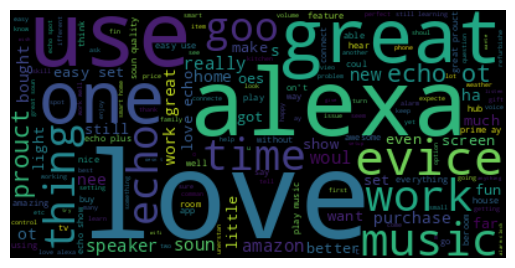

In [9]:
# Visualization common words
common_words = ''
for i in data_v1.verified_reviews:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens) + " "

wordcloud = WordCloud().generate(common_words)  # Corrected 'world' to 'WordCloud'
plt.imshow(wordcloud, interpolation='bilinear')  # Corrected 'bilnear' to 'bilinear'
plt.axis('off')
plt.show()  # Corrected 'plt.shaow()' to 'plt.show()'

In [10]:
# Encode the target column
lb=LabelEncoder()
data_v1['sentiment'] = lb.fit_transform(data_v1['sentiment'])

In [11]:
data_v1.head(10)

,verified_reviews,sentiment
0,love echo!,1
1,love it!,1
2,"sometimes playing game, answer question correc...",1
3,"ha lot fun thing. 4 yr ol learns inosaurs, con...",1
4,music,1
5,receive echo gift. neee another bluetooth some...,1
6,"without cellphone, cannot use many features. i...",0
7,think 5th one i've purchase. i'm working getti...,1
8,look great,1
9,love it! i’ve listene song haven’t hear since ...,1


In [12]:
tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(data_v1['verified_reviews'].values)
X = tokenizer.texts_to_sequences(data['verified_reviews'].values)
X = pad_sequences(X)
X

array([[  0,   0,   0, ...,   0,   1,   2],
       [  0,   0,   0, ...,   0,   0,   5],
       [  0,   0,   0, ..., 263, 276,  24],
       ...,
       [  0,   0,   0, ...,  89, 326,  32],
       [  0,   0,   0, ..., 217,  58, 290],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [13]:
model = Sequential()
model.add(Embedding(500, 120 , input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 319, 120)          60000     
                                                                 
 spatial_dropout1d (Spatial  (None, 319, 120)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 2)                 354       
                                                                 
Total params: 269442 (1.03 MB)
Trainable params: 269442 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [14]:
# Split data into Training and testing
y=pd.get_dummies(data_v1['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)


In [15]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [16]:
batch_size=32
model.fit(X_train, y_train, epochs=5, batch_size=batch_size, verbose =1)

Epoch 1/5
69/69 [==============================] - 127s 2s/step - loss: 0.3870 - accuracy: 0.8667
Epoch 2/5
69/69 [==============================] - 101s 1s/step - loss: 0.3020 - accuracy: 0.8830
Epoch 3/5
69/69 [==============================] - 98s 1s/step - loss: 0.2266 - accuracy: 0.9048
Epoch 4/5
69/69 [==============================] - 101s 1s/step - loss: 0.2096 - accuracy: 0.9156
Epoch 5/5
69/69 [==============================] - 99s 1s/step - loss: 0.1970 - accuracy: 0.9229


In [22]:
model.evaluate(X_test, y_test)

30/30 [==============================] - 6s 179ms/step - loss: 0.2542 - accuracy: 0.9005


[0.25415608286857605, 0.9005290865898132]

In [1]:
!pwd

/content


In [2]:
cd /content/drive/MyDrive


/content/drive/MyDrive
